# Coursework 2 B

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework2.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

### Part B
Construct and train networks containing one and two convolutional layers, and max-pooling layers, using
the Balanced EMNIST data, reporting your experimental results. As a default use convolutional kernels of
dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping). As a default convo-
lutional networks with two convolutional layers, investigate a network with two convolutional+maxpooling
layers with 5 feature maps in the first convolutional layer, and 10 feature maps in the second convolutional
layer.

In [44]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for stats_interval epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import numpy as np
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import ConvolutionalLayer, MaxPoolingLayer, ReshapeLayer, BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.learning_rules import RMSPropLearningRule, AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalty import L1Penalty, L2Penalty
from collections import defaultdict, OrderedDict
import logging
import pickle
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider
################################################################################
# save and present the data
save_stats= defaultdict()
save_results = defaultdict()
def save_and_present(experiment, stats, parameter):
    
    # save the model to disk
    filename = experiment +'.sav'
    pickle.dump(model, open(filename, 'wb'))

    np.savetxt(experiment+'_'+str(parameter)+'.csv', stats, delimiter=',')
    
    error_valid= stats[1:, keys['error(valid)']]
    error_train= stats[1:, keys['error(train)']]
    acc_valid = stats[1:, keys['acc(valid)']]

    file = open(experiment+'_'+str(parameter)+'.txt','w')

    overfitting = error_valid-error_train
    file.write('Experiment '+experiment+' best acc at Epoch={} by parameter={}\n'.
          format(np.argmax(acc_valid)+1, parameter))
    file.write('error(train)= {}, error(valid)={}, \n error gap = {},  acc(valid)={}\n'.
          format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
    file.write('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
          format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))
    print('Experiment '+experiment+' best acc at Epoch={} by parameter={}\n'.
          format(np.argmax(acc_valid)+1, parameter))
    print('error(train)= {}, error(valid)={}, \n error gap = {},  acc(valid)={}\n'.
          format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
    print('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
          format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))

    

################################################################################
# prediction on test data
def prediction(filename, test_data, label='test', error = CrossEntropySoftmaxError()):
    ''' Load the model from file and predict on the test set, 
    prediction(experiment +'.sav', test_data)'''
    # load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    
    data_monitors = OrderedDict([('error', error)])
    data_monitors.update({'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()})
    data_mon_vals = OrderedDict([(key + label, 0.) for key
                                             in data_monitors.keys()])
    for inputs_batch, targets_batch in test_data:
        activations = loaded_model.fprop(inputs_batch, evaluation=True)
        
        for key, data_monitor in data_monitors.items():
            data_mon_vals[key + label] += data_monitor(
                            activations[-1], targets_batch)
    for key, data_monitor in data_monitors.items():
        data_mon_vals[key + label] /= test_data.num_batches
    print('Error:    ' + str(data_mon_vals['errortest']))
    print('Accuracy: ' + str(data_mon_vals['acctest']))
    return data_mon_vals

    

In [50]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the EMNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

['inputs', 'targets']
['inputs', 'targets']
['inputs', 'targets']


In [47]:
print(train_data.next()[0].shape)
test_data.inputs.shape

(100, 784)


(15800, 784)

### Experiments
1. Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
2. Number of filters: Above we used 32 filters. Do more or fewer do better?
3. Batch normalization: Try adding vanilla batch normalization aafter affine layers. Do your networks train faster?
4. Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file cs231n/classifiers/convnet.py. Some good architectures to try include:
    1. [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    2. [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    3. [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]



### Baseline 1: one convolution layer 
INPUT -> CONV -> RELU -> FC

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 121.9s to complete
    error(train)=1.34e+00, acc(train)=6.19e-01, error(valid)=1.34e+00, acc(valid)=6.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 118.7s to complete
    error(train)=1.22e+00, acc(train)=6.58e-01, error(valid)=1.22e+00, acc(valid)=6.58e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 113.7s to complete
    error(train)=1.18e+00, acc(train)=6.68e-01, error(valid)=1.18e+00, acc(valid)=6.67e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 111.6s to complete
    error(train)=1.14e+00, acc(train)=6.80e-01, error(valid)=1.15e+00, acc(valid)=6.76e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 111.9s to complete
    error(train)=1.07e+00, acc(train)=6.95e-01, error(valid)=1.08e+00, acc(valid)=6.91e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 112.4s to complete
    error(train)=9.77e-01, acc(train)=7.24e-01, error(valid)=9.89e-01, acc(valid)=7.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 113.0s to complete
    error(train)=8.89e-01, acc(train)=7.46e-01, error(valid)=9.03e-01, acc(valid)=7.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 111.7s to complete
    error(train)=8.02e-01, acc(train)=7.69e-01, error(valid)=8.19e-01, acc(valid)=7.62e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 112.1s to complete
    error(train)=7.73e-01, acc(train)=7.68e-01, error(valid)=7.89e-01, acc(valid)=7.61e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 112.1s to complete
    error(train)=7.04e-01, acc(train)=7.88e-01, error(valid)=7.30e-01, acc(valid)=7.80e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 111.9s to complete
    error(train)=6.65e-01, acc(train)=7.99e-01, error(valid)=6.92e-01, acc(valid)=7.91e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 114.3s to complete
    error(train)=6.31e-01, acc(train)=8.08e-01, error(valid)=6.60e-01, acc(valid)=8.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 111.0s to complete
    error(train)=6.04e-01, acc(train)=8.17e-01, error(valid)=6.35e-01, acc(valid)=8.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 112.0s to complete
    error(train)=5.86e-01, acc(train)=8.22e-01, error(valid)=6.23e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 112.6s to complete
    error(train)=5.72e-01, acc(train)=8.24e-01, error(valid)=6.09e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 112.4s to complete
    error(train)=5.67e-01, acc(train)=8.22e-01, error(valid)=6.09e-01, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 111.9s to complete
    error(train)=5.59e-01, acc(train)=8.25e-01, error(valid)=6.00e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 111.6s to complete
    error(train)=5.48e-01, acc(train)=8.27e-01, error(valid)=5.92e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 113.6s to complete
    error(train)=5.39e-01, acc(train)=8.31e-01, error(valid)=5.86e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 112.0s to complete
    error(train)=5.29e-01, acc(train)=8.36e-01, error(valid)=5.82e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 111.4s to complete
    error(train)=5.21e-01, acc(train)=8.37e-01, error(valid)=5.74e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 112.1s to complete
    error(train)=5.11e-01, acc(train)=8.39e-01, error(valid)=5.67e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 111.8s to complete
    error(train)=5.10e-01, acc(train)=8.36e-01, error(valid)=5.70e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 111.5s to complete
    error(train)=4.92e-01, acc(train)=8.47e-01, error(valid)=5.55e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 112.0s to complete
    error(train)=4.95e-01, acc(train)=8.45e-01, error(valid)=5.59e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 111.9s to complete
    error(train)=4.97e-01, acc(train)=8.43e-01, error(valid)=5.62e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 112.6s to complete
    error(train)=4.87e-01, acc(train)=8.46e-01, error(valid)=5.53e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 111.6s to complete
    error(train)=4.85e-01, acc(train)=8.46e-01, error(valid)=5.56e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 111.6s to complete
    error(train)=4.71e-01, acc(train)=8.52e-01, error(valid)=5.42e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 112.1s to complete
    error(train)=4.69e-01, acc(train)=8.52e-01, error(valid)=5.41e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 111.6s to complete
    error(train)=4.70e-01, acc(train)=8.49e-01, error(valid)=5.44e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 112.0s to complete
    error(train)=4.59e-01, acc(train)=8.54e-01, error(valid)=5.37e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 112.8s to complete
    error(train)=4.58e-01, acc(train)=8.55e-01, error(valid)=5.39e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 112.8s to complete
    error(train)=4.60e-01, acc(train)=8.54e-01, error(valid)=5.44e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 113.2s to complete
    error(train)=4.48e-01, acc(train)=8.57e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 112.3s to complete
    error(train)=4.55e-01, acc(train)=8.55e-01, error(valid)=5.41e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 113.3s to complete
    error(train)=4.41e-01, acc(train)=8.59e-01, error(valid)=5.30e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 113.0s to complete
    error(train)=4.56e-01, acc(train)=8.52e-01, error(valid)=5.43e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 112.6s to complete
    error(train)=4.36e-01, acc(train)=8.58e-01, error(valid)=5.26e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 113.2s to complete
    error(train)=4.51e-01, acc(train)=8.53e-01, error(valid)=5.42e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 111.5s to complete
    error(train)=4.27e-01, acc(train)=8.62e-01, error(valid)=5.20e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 112.0s to complete
    error(train)=4.36e-01, acc(train)=8.57e-01, error(valid)=5.30e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 113.4s to complete
    error(train)=4.28e-01, acc(train)=8.61e-01, error(valid)=5.27e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 112.2s to complete
    error(train)=4.33e-01, acc(train)=8.58e-01, error(valid)=5.33e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 111.5s to complete
    error(train)=4.21e-01, acc(train)=8.64e-01, error(valid)=5.21e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 112.9s to complete
    error(train)=4.18e-01, acc(train)=8.66e-01, error(valid)=5.21e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 111.5s to complete
    error(train)=4.12e-01, acc(train)=8.67e-01, error(valid)=5.16e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 111.6s to complete
    error(train)=4.09e-01, acc(train)=8.67e-01, error(valid)=5.14e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 111.6s to complete
    error(train)=4.09e-01, acc(train)=8.68e-01, error(valid)=5.16e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 113.2s to complete
    error(train)=4.13e-01, acc(train)=8.66e-01, error(valid)=5.24e-01, acc(valid)=8.33e-01



Experiment Con_re_af best acc at Epoch=48 by parameter=0.01

error(train)= 0.40892465624777047, error(valid)=0.5138483423579665, 
 error gap = 0.10492368611019603,  acc(valid)=0.8374683544303797

Smallest error gap(after best acc epoch) = 0.10492368611019603 at Epoch=48
Test error:    0.566772818846
Test accuracy: 0.823227848101


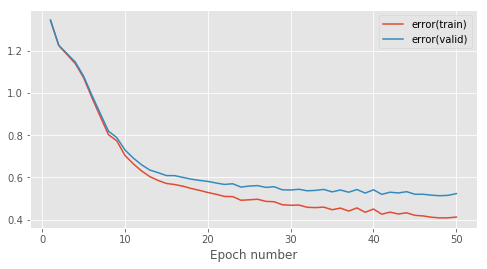

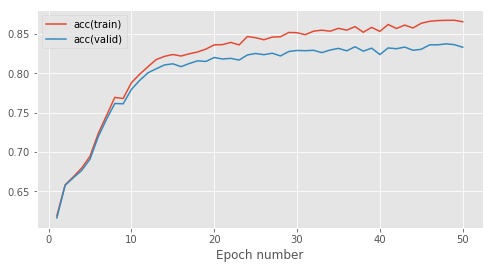

In [17]:
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.01
num_epochs = 50
stats_interval = 1

pad=0
stride=1
# First layer kernel shape
num_output_channels, kernel_dim_1, kernel_dim_2 = 5,5,5
# Initial input, final output shape
inputs_units, output_dim = 784, 47
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer + maxpool is (batch_size, num_output_channels, Con_out_1, Con_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
#Max_out_1 = Con_out_1//2
# then reshaped to (batch_size, num_output_channels* Con_out_1* Con_out_1)
Fc_in = num_output_channels* Con_out_1* Con_out_1

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    ReshapeLayer(), 
    ReluLayer(),
    
    #MaxPoolingLayer(),
    #ReshapeLayer(), 
    #ReluLayer(),
    
    AffineLayer(Fc_in, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate,)


experiment = 'Con_re_af'

#return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

save_results[experiment] = optimiser.eval_monitors(test_data, 'test')
print('Test error:    ' + str(save_results[experiment]['errortest']))
print('Test accuracy: ' + str(save_results[experiment]['acctest']))



### Baseline 2:  one conv + pool layer
INPUT -> CONV -> RELU -> POOL -> FC -> RELU -> FC  


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 129.0s to complete
    error(train)=1.50e+00, acc(train)=5.86e-01, error(valid)=1.50e+00, acc(valid)=5.79e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 135.2s to complete
    error(train)=1.17e+00, acc(train)=6.65e-01, error(valid)=1.17e+00, acc(valid)=6.62e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 135.9s to complete
    error(train)=1.03e+00, acc(train)=7.00e-01, error(valid)=1.04e+00, acc(valid)=6.96e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 138.9s to complete
    error(train)=9.28e-01, acc(train)=7.25e-01, error(valid)=9.37e-01, acc(valid)=7.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 133.6s to complete
    error(train)=8.75e-01, acc(train)=7.37e-01, error(valid)=8.84e-01, acc(valid)=7.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 136.8s to complete
    error(train)=8.24e-01, acc(train)=7.47e-01, error(valid)=8.37e-01, acc(valid)=7.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 133.4s to complete
    error(train)=7.70e-01, acc(train)=7.64e-01, error(valid)=7.80e-01, acc(valid)=7.65e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 134.0s to complete
    error(train)=7.28e-01, acc(train)=7.79e-01, error(valid)=7.42e-01, acc(valid)=7.76e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 133.9s to complete
    error(train)=6.92e-01, acc(train)=7.87e-01, error(valid)=7.06e-01, acc(valid)=7.83e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 134.0s to complete
    error(train)=6.66e-01, acc(train)=7.94e-01, error(valid)=6.83e-01, acc(valid)=7.88e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 128.3s to complete
    error(train)=6.58e-01, acc(train)=7.94e-01, error(valid)=6.77e-01, acc(valid)=7.90e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 129.3s to complete
    error(train)=6.22e-01, acc(train)=8.02e-01, error(valid)=6.40e-01, acc(valid)=7.95e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 126.7s to complete
    error(train)=6.10e-01, acc(train)=8.07e-01, error(valid)=6.29e-01, acc(valid)=8.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 127.0s to complete
    error(train)=5.84e-01, acc(train)=8.17e-01, error(valid)=6.07e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 120.6s to complete
    error(train)=5.69e-01, acc(train)=8.20e-01, error(valid)=5.91e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 123.6s to complete
    error(train)=5.59e-01, acc(train)=8.21e-01, error(valid)=5.81e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 124.4s to complete
    error(train)=5.47e-01, acc(train)=8.25e-01, error(valid)=5.69e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 129.2s to complete
    error(train)=5.30e-01, acc(train)=8.27e-01, error(valid)=5.57e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 128.4s to complete
    error(train)=5.13e-01, acc(train)=8.35e-01, error(valid)=5.41e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 128.7s to complete
    error(train)=5.17e-01, acc(train)=8.33e-01, error(valid)=5.48e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 129.7s to complete
    error(train)=5.01e-01, acc(train)=8.36e-01, error(valid)=5.32e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 131.7s to complete
    error(train)=5.01e-01, acc(train)=8.36e-01, error(valid)=5.35e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 124.5s to complete
    error(train)=4.82e-01, acc(train)=8.42e-01, error(valid)=5.15e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 127.8s to complete
    error(train)=4.96e-01, acc(train)=8.33e-01, error(valid)=5.33e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 150.5s to complete
    error(train)=4.65e-01, acc(train)=8.47e-01, error(valid)=5.04e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 212.4s to complete
    error(train)=4.63e-01, acc(train)=8.48e-01, error(valid)=5.01e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 210.0s to complete
    error(train)=4.50e-01, acc(train)=8.52e-01, error(valid)=4.91e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 220.5s to complete
    error(train)=4.48e-01, acc(train)=8.51e-01, error(valid)=4.90e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 204.2s to complete
    error(train)=4.43e-01, acc(train)=8.53e-01, error(valid)=4.86e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 208.9s to complete
    error(train)=4.39e-01, acc(train)=8.53e-01, error(valid)=4.82e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 210.4s to complete
    error(train)=4.37e-01, acc(train)=8.54e-01, error(valid)=4.82e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 181.7s to complete
    error(train)=4.35e-01, acc(train)=8.55e-01, error(valid)=4.82e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 166.6s to complete
    error(train)=4.23e-01, acc(train)=8.58e-01, error(valid)=4.70e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 120.4s to complete
    error(train)=4.15e-01, acc(train)=8.61e-01, error(valid)=4.61e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 121.5s to complete
    error(train)=4.15e-01, acc(train)=8.62e-01, error(valid)=4.65e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 134.1s to complete
    error(train)=4.18e-01, acc(train)=8.59e-01, error(valid)=4.72e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 127.9s to complete
    error(train)=4.03e-01, acc(train)=8.64e-01, error(valid)=4.57e-01, acc(valid)=8.46e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 131.3s to complete
    error(train)=4.08e-01, acc(train)=8.59e-01, error(valid)=4.64e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 125.5s to complete
    error(train)=4.08e-01, acc(train)=8.60e-01, error(valid)=4.65e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 123.7s to complete
    error(train)=3.94e-01, acc(train)=8.67e-01, error(valid)=4.49e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 127.4s to complete
    error(train)=3.92e-01, acc(train)=8.67e-01, error(valid)=4.49e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 135.0s to complete
    error(train)=3.96e-01, acc(train)=8.62e-01, error(valid)=4.55e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 130.4s to complete
    error(train)=3.87e-01, acc(train)=8.68e-01, error(valid)=4.48e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 129.0s to complete
    error(train)=3.81e-01, acc(train)=8.70e-01, error(valid)=4.43e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 136.7s to complete
    error(train)=3.81e-01, acc(train)=8.67e-01, error(valid)=4.43e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 134.5s to complete
    error(train)=3.75e-01, acc(train)=8.73e-01, error(valid)=4.40e-01, acc(valid)=8.53e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 133.2s to complete
    error(train)=3.72e-01, acc(train)=8.73e-01, error(valid)=4.35e-01, acc(valid)=8.54e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 137.7s to complete
    error(train)=3.77e-01, acc(train)=8.69e-01, error(valid)=4.44e-01, acc(valid)=8.52e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 145.0s to complete
    error(train)=3.75e-01, acc(train)=8.71e-01, error(valid)=4.44e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 135.4s to complete
    error(train)=3.75e-01, acc(train)=8.68e-01, error(valid)=4.46e-01, acc(valid)=8.48e-01


NameError: name 'pickle' is not defined

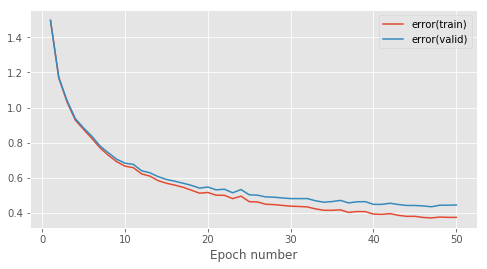

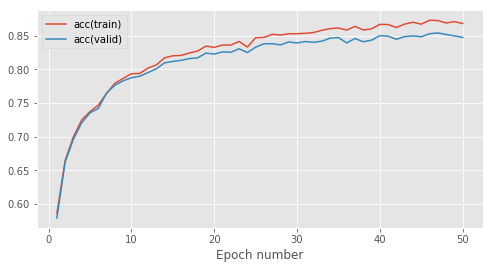

In [53]:
rng.seed(seed)
#setup hyperparameters
learning_rate = 0.01
num_epochs = 50
stats_interval = 1

pad=0
stride=1
# First layer kernel shape
num_output_channels, kernel_dim_1, kernel_dim_2 = 5,5,5
# Initial input, final output shape
inputs_units, output_dim, hidden_dim = 784, 47, 100
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer + maxpool is (batch_size, num_output_channels, Con_out_1, Con_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
Max_out_1 = Con_out_1//2
# then reshaped to (batch_size, num_output_channels* Con_out_1* Con_out_1)
Fc_in = num_output_channels* Max_out_1* Max_out_1

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),

    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    #ReshapeLayer(), 
    ReluLayer(),
    #ReshapeLayer((num_output_channels, Con_out_1, Con_out_1)),
    MaxPoolingLayer(),
    
    ReshapeLayer(),  
    AffineLayer(Fc_in, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate,)


experiment = 'Con_re_pool_sgd'

#return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

#save_results[experiment] = optimiser.eval_monitors(test_data, 'test')
#print('Test error:    ' + str(save_results[experiment]['errortest']))
#print('Test accuracy: ' + str(save_results[experiment]['acctest']))

In [55]:
save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

Experiment Con_re_pool_sgd best acc at Epoch=47 by parameter=0.01

error(train)= 0.37204820575972225, error(valid)=0.435394788052284, 
 error gap = 0.06334658229256174,  acc(valid)=0.854303797468354

Smallest error gap(after best acc epoch) = 0.06334658229256174 at Epoch=47


#### Con_relu_pool_x2_af_re_af_sgd

In [ ]:
rng.seed(seed)

#setup hyperparameters
learning_rate = 1e-3
num_epochs = 1Relu_x2
stats_interval = 1

pad=0
stride=1
# kernel shape and feature maps
num_output_channels1, num_output_channels2, kernel_dim_1, kernel_dim_2 = 5,10,5,5
# Initial input, final output shape
inputs_units, output_dim, hidden_dim = 784, 47, 256
#####################################################################################################
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer is (batch_size, num_output_channels, Con_out_1, Con_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
# Flatten the image for relu
# Reshape to image shape for first Maxpool
# the ouput shape of the first Maxpool 
Max_out_1 = Con_out_1//2
#####################################################################################################
# The input shape of the second conv layer

# the ouput shape of the second convol layer is (batch_size, num_output_channels2, Con_out_2, Con_out_2)
Con_out_2 = (Max_out_1 - kernel_dim_1+2*pad)//stride + 1
# Flatten the image for relu
# Rehape to image shape for second maxpool
num_input_channels3, input_dim_1_4, input_dim_2_4 = num_output_channels2, Con_out_2, Con_out_2
# the ouput shape of the second Maxpool 
Max_out_2 = Con_out_2//2
#####################################################################################################
# then flatten the output
Fc_in = num_output_channels2* Max_out_2* Max_out_2

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),

    ConvolutionalLayer(num_input_channels, num_output_channels1, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    ReshapeLayer(), 
    ReluLayer(),
    ReshapeLayer((num_output_channels1, Con_out_1, Con_out_1)),
    MaxPoolingLayer(),
    
    ConvolutionalLayer(num_output_channels1, num_output_channels2, Max_out_1, Max_out_1, kernel_dim_1, kernel_dim_2),
    ReshapeLayer(), 
    ReluLayer(),
    ReshapeLayer((num_output_channels2, Con_out_2, Con_out_2)),
    MaxPoolingLayer(),
    
    ReshapeLayer(), 
    AffineLayer(Fc_in, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate,)

experiment = 'Con_relu_pool_x2_af_re_af_sgd'

#return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=False)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats


result = optimiser.eval_monitors(test_data, 'test')
print('Error:    ' + str(result['errortest']))
print('Accuracy: ' + str(result['acctest']))


### One Conv+ Maxpooling layer


In [ ]:
%reload_ext autoreload
%autoreload 2

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import ConvolutionalLayer, MaxPoolingLayer, ReshapeLayer, BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 100
stats_interval = 1

pad=0
stride=1
# First layer kernel shape
num_output_channels, kernel_dim_1, kernel_dim_2 = 5,5,5
# Initial input, final output shape
inputs_units, output_dim = 784, 47
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer + maxpool is (batch_size, num_output_channels, Con_out_1, Con_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
Max_out_1 = Con_out_1//2
# then reshaped to (batch_size, num_output_channels* Con_out_1* Con_out_1)
hidden_dim = num_output_channels* Max_out_1* Max_out_1

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(),
    ReshapeLayer(), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)

save_and_present('Con_pool_x2')

#return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
stats_con_max1, keys, run_time, fig_1_con_max1, ax_1, fig_2_con_max1, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1_con_max1.savefig('error_con1_learning_rate_{}.pdf'.format(learning_rate))
fig_2_con_max1.savefig('accuracy_con1_learning_rate_{}.pdf'.format(learning_rate))

_  = stats_con_max1
error_valid= _[1:, keys['error(valid)']]
error_train= _[1:, keys['error(train)']]
acc_valid = _[1:, keys['acc(valid)']]
overfitting = error_valid-error_train
print('Best acc at Epoch={} by learning_rate={}'.
      format(np.argmax(acc_valid)+1,learning_rate))
print('error(train)= {}, error(valid)={}, \n                             error gap = {},  acc(valid)={}'.
      format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
print('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
      format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))

### 2 Convolve+ MaxPooling layer

In [ ]:
%reload_ext autoreload
%autoreload 2

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import ConvolutionalLayer, MaxPoolingLayer, ReshapeLayer, BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 50
stats_interval = 1

pad=0
stride=1
# First layer kernel shape
num_output_channels1, num_output_channels2, kernel_dim_1, kernel_dim_2 = 5,10,5,5
# Initial input, final output shape
inputs_units, output_dim = 784, 47
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer + maxpool is (batch_size, num_output_channels, Max_out_1, Max_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
Max_out_1 = Con_out_1//2
# the ouput shape of the second convol layer + maxpool is (batch_size, num_output_channels2, Max_out_2, Max_out_2)
Con_out_2 = (Max_out_1 - kernel_dim_1+2*pad)//stride + 1 
Max_out_2 = Con_out_2//2
# then reshaped to (batch_size, num_output_channels* Con_out_1* Con_out_1)
hidden_dim = num_output_channels2* Max_out_2* Max_out_2

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),
    ConvolutionalLayer(num_input_channels, num_output_channels1, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(),
    ConvolutionalLayer(num_output_channels1, num_output_channels2, Max_out_1, Max_out_1, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(),
    ReshapeLayer(), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)


experiment = 'Con_pool_x2'
#return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig('error_'+ experiment +'_learning_rate_{}.pdf'.format(learning_rate))
fig_2.savefig('accuracy_'+ experiment +'_learning_rate_{}.pdf'.format(learning_rate))

save_and_present(experiment, stats)

save_stats[experiment] = stats

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 1: 1622.2s to complete
    error(train)=5.97e-01, acc(train)=8.07e-01, error(valid)=6.03e-01, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 2: 1597.8s to complete
    error(train)=5.37e-01, acc(train)=8.26e-01, error(valid)=5.49e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 3: 1601.4s to complete
    error(train)=5.00e-01, acc(train)=8.35e-01, error(valid)=5.15e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 4: 1577.7s to complete
    error(train)=4.77e-01, acc(train)=8.42e-01, error(valid)=5.01e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 5: 1588.6s to complete
    error(train)=4.53e-01, acc(train)=8.49e-01, error(valid)=4.73e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 6: 1618.4s to complete
    error(train)=4.47e-01, acc(train)=8.51e-01, error(valid)=4.69e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 7: 2145.6s to complete
    error(train)=4.38e-01, acc(train)=8.54e-01, error(valid)=4.63e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 8: 2246.7s to complete
    error(train)=4.32e-01, acc(train)=8.56e-01, error(valid)=4.60e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 9: 1531.9s to complete
    error(train)=4.18e-01, acc(train)=8.58e-01, error(valid)=4.53e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 10: 1532.9s to complete
    error(train)=4.10e-01, acc(train)=8.62e-01, error(valid)=4.44e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 11: 1537.6s to complete
    error(train)=4.13e-01, acc(train)=8.61e-01, error(valid)=4.49e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 12: 1538.4s to complete
    error(train)=4.08e-01, acc(train)=8.59e-01, error(valid)=4.47e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 13: 1538.9s to complete
    error(train)=4.02e-01, acc(train)=8.64e-01, error(valid)=4.39e-01, acc(valid)=8.55e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 14: 1537.1s to complete
    error(train)=3.98e-01, acc(train)=8.65e-01, error(valid)=4.37e-01, acc(valid)=8.53e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 15: 1542.1s to complete
    error(train)=3.97e-01, acc(train)=8.65e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 16: 1537.0s to complete
    error(train)=3.95e-01, acc(train)=8.64e-01, error(valid)=4.37e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 17: 1536.3s to complete
    error(train)=4.00e-01, acc(train)=8.63e-01, error(valid)=4.45e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 18: 1537.2s to complete
    error(train)=3.88e-01, acc(train)=8.66e-01, error(valid)=4.32e-01, acc(valid)=8.52e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 19: 1533.6s to complete
    error(train)=3.86e-01, acc(train)=8.68e-01, error(valid)=4.31e-01, acc(valid)=8.52e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 20: 1536.8s to complete
    error(train)=3.80e-01, acc(train)=8.70e-01, error(valid)=4.25e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 21: 1539.9s to complete
    error(train)=3.88e-01, acc(train)=8.68e-01, error(valid)=4.37e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 22: 1533.3s to complete
    error(train)=3.74e-01, acc(train)=8.71e-01, error(valid)=4.24e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 23: 1543.2s to complete
    error(train)=3.75e-01, acc(train)=8.71e-01, error(valid)=4.22e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 24: 1535.4s to complete
    error(train)=3.80e-01, acc(train)=8.69e-01, error(valid)=4.28e-01, acc(valid)=8.54e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 25: 1538.2s to complete
    error(train)=3.76e-01, acc(train)=8.71e-01, error(valid)=4.28e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 26: 1537.7s to complete
    error(train)=3.77e-01, acc(train)=8.70e-01, error(valid)=4.29e-01, acc(valid)=8.55e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 27: 1545.1s to complete
    error(train)=3.79e-01, acc(train)=8.67e-01, error(valid)=4.30e-01, acc(valid)=8.54e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 28: 1535.3s to complete
    error(train)=3.79e-01, acc(train)=8.71e-01, error(valid)=4.31e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 29: 1542.5s to complete
    error(train)=3.70e-01, acc(train)=8.71e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 30: 1535.5s to complete
    error(train)=3.67e-01, acc(train)=8.73e-01, error(valid)=4.23e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 31: 1533.7s to complete
    error(train)=3.77e-01, acc(train)=8.68e-01, error(valid)=4.36e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 32: 1536.1s to complete
    error(train)=3.69e-01, acc(train)=8.70e-01, error(valid)=4.27e-01, acc(valid)=8.53e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 33: 1539.2s to complete
    error(train)=3.67e-01, acc(train)=8.74e-01, error(valid)=4.22e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 34: 1535.3s to complete
    error(train)=3.64e-01, acc(train)=8.74e-01, error(valid)=4.26e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 35: 1538.7s to complete
    error(train)=3.63e-01, acc(train)=8.74e-01, error(valid)=4.22e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 36: 1533.3s to complete
    error(train)=3.69e-01, acc(train)=8.69e-01, error(valid)=4.26e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 37: 1529.0s to complete
    error(train)=3.65e-01, acc(train)=8.73e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 38: 1524.8s to complete
    error(train)=3.64e-01, acc(train)=8.74e-01, error(valid)=4.23e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 39: 1536.4s to complete
    error(train)=3.64e-01, acc(train)=8.72e-01, error(valid)=4.27e-01, acc(valid)=8.54e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 40: 1539.5s to complete
    error(train)=3.65e-01, acc(train)=8.72e-01, error(valid)=4.22e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 41: 1528.7s to complete
    error(train)=3.70e-01, acc(train)=8.68e-01, error(valid)=4.30e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 42: 1531.7s to complete
    error(train)=3.64e-01, acc(train)=8.73e-01, error(valid)=4.24e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 43: 1536.3s to complete
    error(train)=3.64e-01, acc(train)=8.71e-01, error(valid)=4.27e-01, acc(valid)=8.57e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch 44: 1538.3s to complete
    error(train)=3.79e-01, acc(train)=8.66e-01, error(valid)=4.37e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

###  Conv - Relu - MaxPool - Conv - Relu - MaxPool
Adding relu layer between conv and pooling layer
[conv-relu-pool]x2 - relu - [softmax]

In [ ]:
%reload_ext autoreload
%autoreload 2

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import ConvolutionalLayer, MaxPoolingLayer, ReshapeLayer, BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 30
stats_interval = 1

pad=0
stride=1
# kernel shape and feature maps
num_output_channels1, num_output_channels2, kernel_dim_1, kernel_dim_2 = 5,10,5,5
# Initial input, final output shape
inputs_units, output_dim = 784, 47
#####################################################################################################
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer is (batch_size, num_output_channels, Con_out_1, Con_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
# Flatten the image for relu
# Reshape to image shape for first Maxpool
# the ouput shape of the first Maxpool 
Max_out_1 = Con_out_1//2
#####################################################################################################
# The input shape of the second conv layer

# the ouput shape of the second convol layer is (batch_size, num_output_channels2, Con_out_2, Con_out_2)
Con_out_2 = (Max_out_1 - kernel_dim_1+2*pad)//stride + 1
# Flatten the image for relu
# Rehape to image shape for second maxpool
num_input_channels3, input_dim_1_4, input_dim_2_4 = num_output_channels2, Con_out_2, Con_out_2
# the ouput shape of the second Maxpool 
Max_out_2 = Con_out_2//2
#####################################################################################################
# then flatten the output
hidden_dim = num_output_channels2* Max_out_2* Max_out_2

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),
    ConvolutionalLayer(num_input_channels, num_output_channels1, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    ReshapeLayer(), 
    ReluLayer(),
    ReshapeLayer((num_output_channels1, Con_out_1, Con_out_1)),
    MaxPoolingLayer(),
    
    ConvolutionalLayer(num_output_channels1, num_output_channels2, Max_out_1, Max_out_1, kernel_dim_1, kernel_dim_2),
    ReshapeLayer(), 
    ReluLayer(),
    MaxPoolingLayer(),
    ReshapeLayer(), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)

_exm = 'Con_relu_max_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig('error_'+ _exm +'_learning_rate_{}.pdf'.format(learning_rate))
fig_2.savefig('accuracy_'+ _exm +'_learning_rate_{}.pdf'.format(learning_rate))

#_ = stats_con_max2

save_stats[_exm]=stats

np.savetxt(_exm +'.csv', stats, delimiter=',')

error_valid= stats[1:, keys['error(valid)']]
error_train= stats[1:, keys['error(train)']]
acc_valid = stats[1:, keys['acc(valid)']]

overfitting = error_valid-error_train
print('Best acc at Epoch={} by learning_rate={}'.
      format(np.argmax(acc_valid)+1,learning_rate))
print('error(train)= {}, error(valid)={}, \n                             error gap = {},  acc(valid)={}'.
      format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
print('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
      format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))

### 2 Converlution+ MaxPooling layer with batch normalisation 
Adding vanilla batch normalization after affine layers.


In [ ]:
%reload_ext autoreload
%autoreload 2

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import ConvolutionalLayer, MaxPoolingLayer, ReshapeLayer, BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.001
num_epochs = 30
stats_interval = 1

pad=0
stride=1
# First layer kernel shape
num_output_channels1, num_output_channels2, kernel_dim_1, kernel_dim_2 = 5,10,5,5
# Initial input, final output shape
inputs_units, output_dim = 784, 47
# Rehape to image shape for first convol
num_input_channels, input_dim_1, input_dim_2 = 1, 28, 28
# the ouput shape of the first convol layer + maxpool is (batch_size, num_output_channels, Max_out_1, Max_out_1)
Con_out_1 =  (input_dim_1 - kernel_dim_1+2*pad)//stride + 1 
Max_out_1 = Con_out_1//2
# the ouput shape of the second convol layer + maxpool is (batch_size, num_output_channels2, Max_out_2, Max_out_2)
Con_out_2 = (Max_out_1 - kernel_dim_1+2*pad)//stride + 1 
Max_out_2 = Con_out_2//2
# then reshaped to (batch_size, num_output_channels* Con_out_1* Con_out_1)
hidden_dim = num_output_channels2* Max_out_2* Max_out_2

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim_1,input_dim_2)),
    ConvolutionalLayer(num_input_channels, num_output_channels1, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(),
    ConvolutionalLayer(num_output_channels1, num_output_channels2, Max_out_1, Max_out_1, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(),
    ReshapeLayer(), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)

#return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
stats_con_max2, keys, run_time, fig_1_con_max2, ax_1, fig_2_con_max2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1_con_max2.savefig('error_con_max2_learning_rate_{}.pdf'.format(learning_rate))
fig_2_con_max2.savefig('accuracy_con_max2_learning_rate_{}.pdf'.format(learning_rate))

_stats_name = 'stats_con_max2'
_ = stats_con_max2

save_stats[_stats_name] = _
np.savetxt(_stats_name +'.csv', _, delimiter=',')

error_valid= _[1:, keys['error(valid)']]
error_train= _[1:, keys['error(train)']]
acc_valid = _[1:, keys['acc(valid)']]
overfitting = error_valid-error_train
print('Best acc at Epoch={} by learning_rate={}'.
      format(np.argmax(acc_valid)+1,learning_rate))
print('error(train)= {}, error(valid)={}, \n                             error gap = {},  acc(valid)={}'.
      format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
print('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
      format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))

### Adam learning rules